# Time Series Analysis on PJME Hourly Energy Consumption

In this notebook we will focus on forecasting hourly energy consumption. We will use **PJME_hourly** dataset provided by PJM, a regional transmission organization in the United States. This dataset is a record of energy consumption of the  eastern section of the U.S., combining multiple states, from January 2002 to August 2018.

## What we will be doing?
Our goal is to predict future energy consumption with a decent accuracy. By analyzing the historical data in the PJME_hourly dataset, we seek to:

- Look at the patterns and visualize energy consumption trends.
- Identify seasonality, trends, and anomalies.
- Plus, we will use **Facebook's Prophet** one of the methods in time series forecasting to predict energy consumption.

## Methodology
Our analysis will proceed through several key stages:

1. **Data Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering**
4. **Model Building**

## Tools and Libraries
This analysis will utilize a range of Python libraries, including:

- `pandas` and `numpy` for data manipulation and numerical computations.
- `matplotlib` and `seaborn` for visualizing data trends and patterns.
- `fbprophet` for implementing Facebook's Prophet model.
- `sklearn` for additional modeling tools and performance metrics.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

C:\Users\Amino\AppData\Local\Temp\ipykernel_1200\926840655.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
df = pd.read_csv("PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [ ]:
# Converting date into Pandas datetime and setting them as index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [ ]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [ ]:
df.shape

(145366, 1)

In [ ]:
df.isnull().sum()

PJME_MW    0
dtype: int64

No missing values, we can move on to eda

# EDA
Taking quick looks at the data in different time intervals to get a general understanding of any patterns or consistencies.


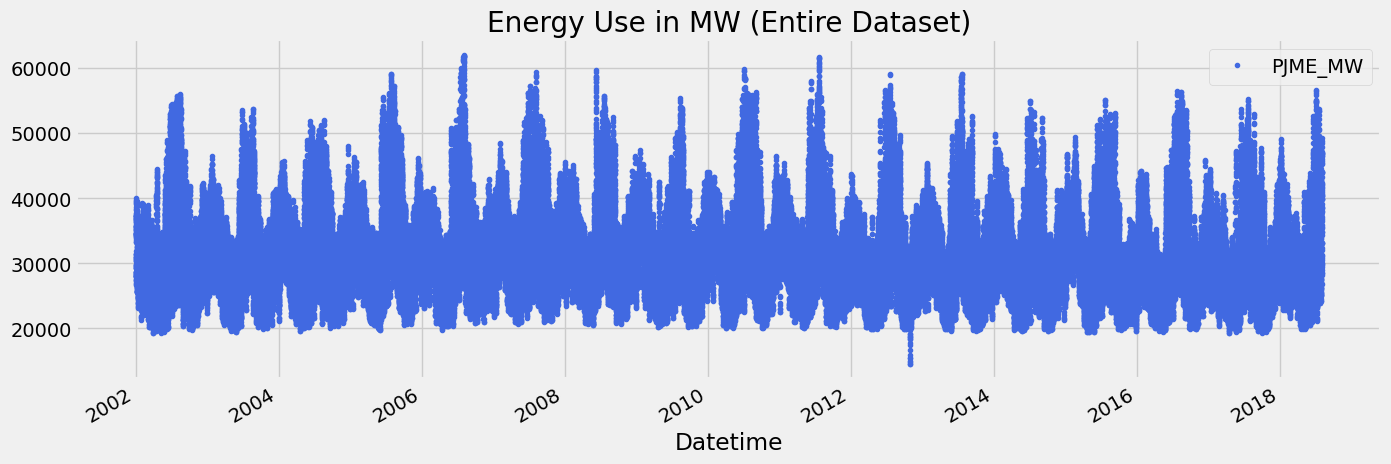

In [ ]:
plt.style.use('fivethirtyeight')

# Plotting the entire dataset
df.plot(style='.',
        figsize=(15, 5),
        color='royalblue',
        title='Energy Use in MW (Entire Dataset)')
plt.show()

Strong seasonality with peaks through each year

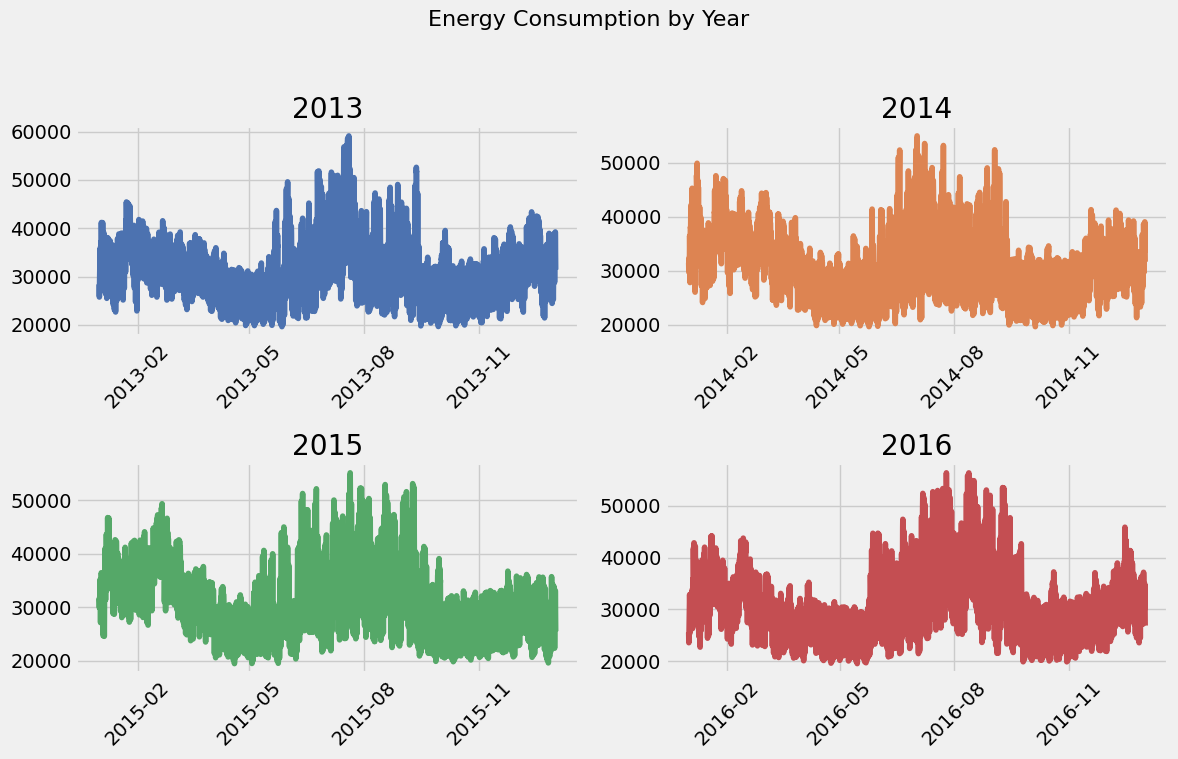

In [ ]:
# Plotting 4 graphs, one for each year of energy consumption 2013-2016

year_one = df.loc[(df.index >= '2013-01-01 01:00:00') & (df.index <= '2014-01-01 01:00:00')]
year_two = df.loc[(df.index >= '2014-01-01 01:00:00') & (df.index <= '2015-01-01 01:00:00')]
year_three = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index <= '2016-01-01 01:00:00')]
year_four = df.loc[(df.index >= '2016-01-01 01:00:00') & (df.index <= '2017-01-01 01:00:00')]
years = [year_one, year_two, year_three, year_four]
year_labels = ['2013', '2014', '2015', '2016']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Year', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('deep', 4)

for i, year in enumerate(years):
    axes[i].plot(year.index, year['PJME_MW'], color=colors[i])
    axes[i].set_title(year_labels[i])
    axes[i].set
    
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Setting x axis tick marks/intervals
    
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

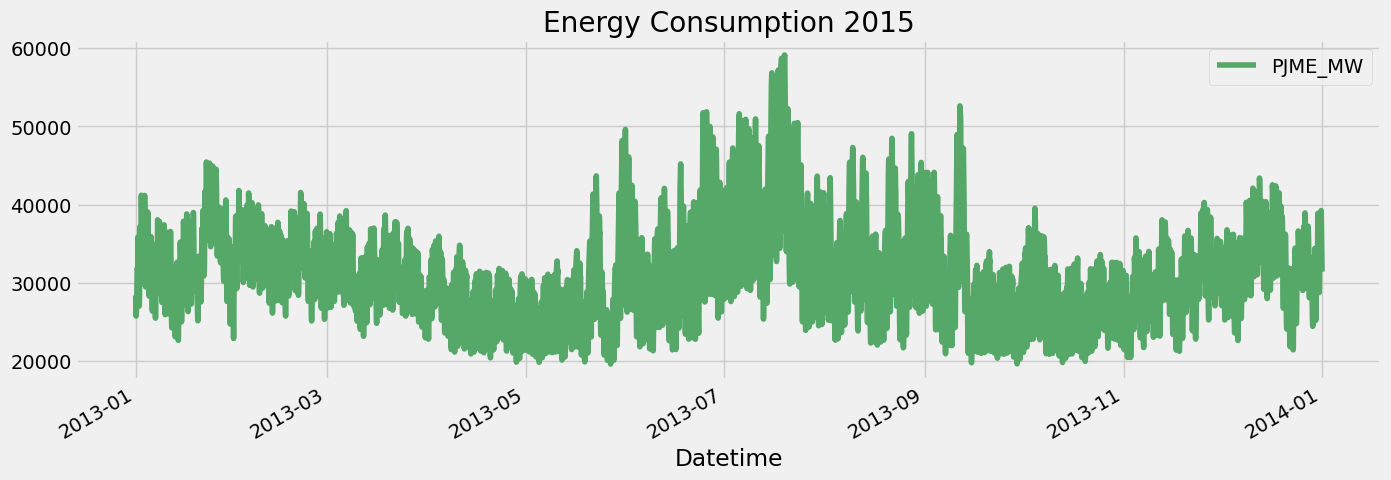

In [ ]:
# Looking closer at a year
year_one.plot(figsize=(15, 5),
              title="Energy Consumption 2015",
              color=colors[2])
plt.show()

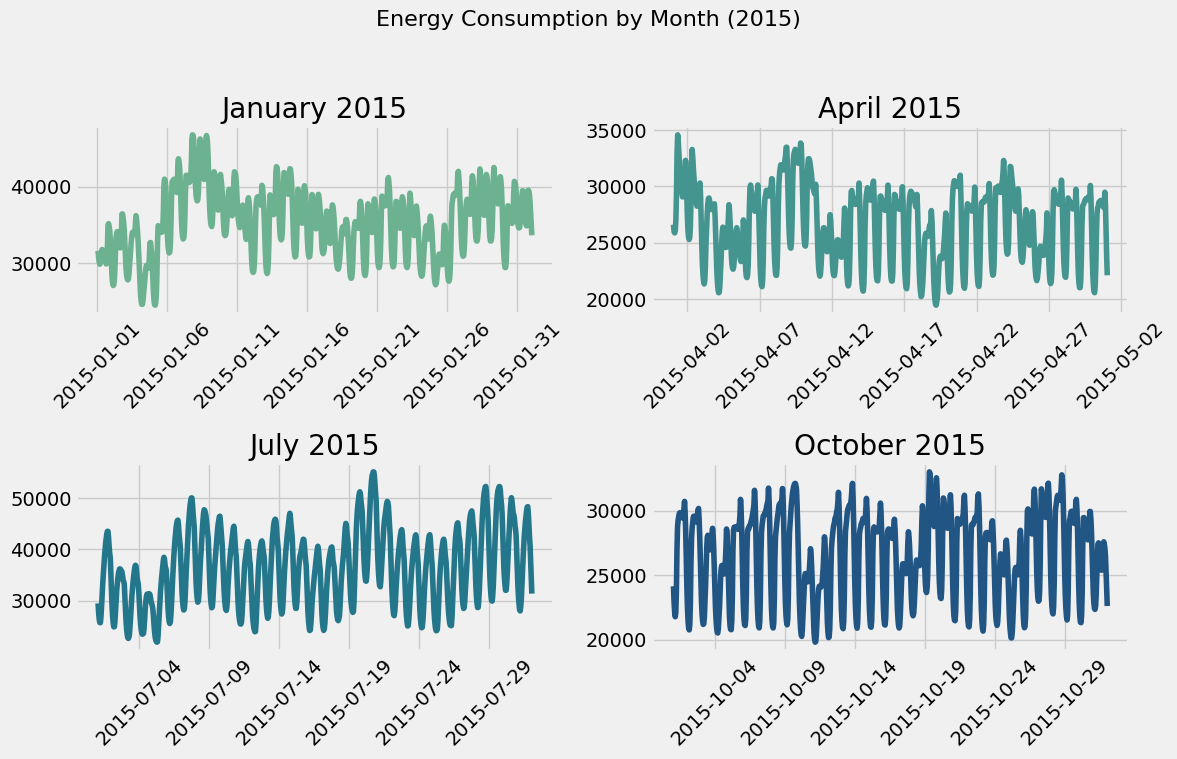

In [ ]:
# Plotting 4 graphs, one for each month of energy consumption for each season 
# We will plot January, April, July, and October for Winter, Spring, Summer, Fall
month_one = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index <= '2015-02-01 01:00:00')]
month_two = df.loc[(df.index >= '2015-04-01 01:00:00') & (df.index <= '2015-05-01 01:00:00')]
month_three = df.loc[(df.index >= '2015-07-01 01:00:00') & (df.index <= '2015-08-01 01:00:00')]
month_four = df.loc[(df.index >= '2015-10-01 01:00:00') & (df.index <= '2015-11-01 01:00:00')]
months = [month_one, month_two, month_three, month_four]
month_labels = ['January 2015', 'April 2015', 'July 2015', 'October 2015']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Month (2015)', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('crest', 4)

for i, month in enumerate(months):
    axes[i].plot(month.index, month['PJME_MW'], color = colors[i])
    axes[i].set_title(month_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
    
    axes[i].tick_params(axis='x', rotation=45) 
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()

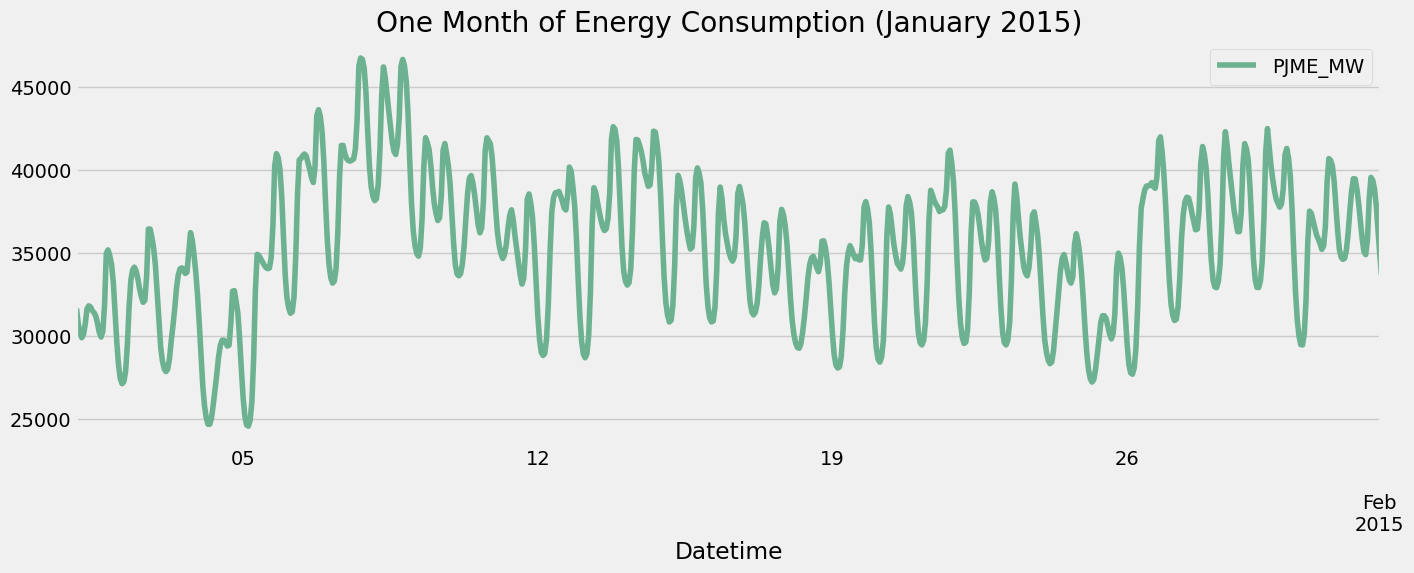

In [ ]:
# Taking a closer look at one month
month_one.plot(figsize=(15, 5),
              title="One Month of Energy Consumption (January 2015)",
              color=colors[0])
plt.show()

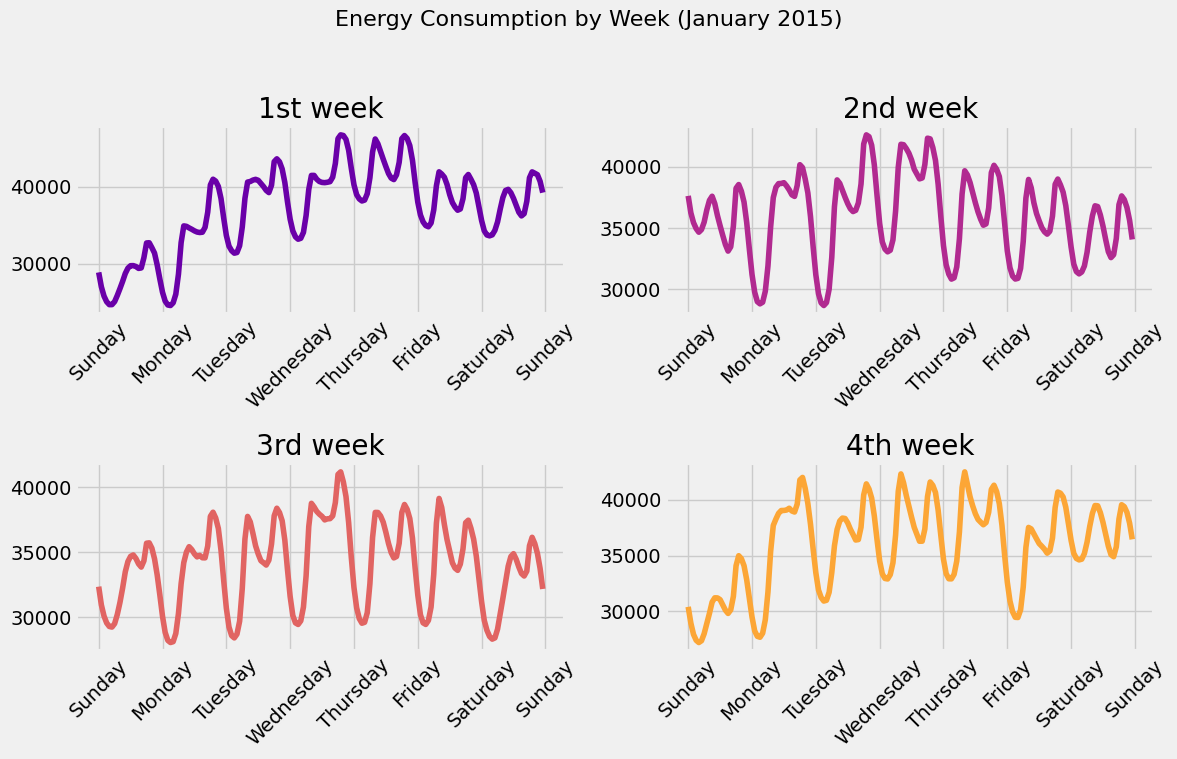

In [ ]:
# Plotting 4 graphs, one for each week of energy consumption January 2015
# Starting on January 4th as its a Sunday
# Plotting Sunday - Saturday for each week
week_one = df.loc[(df.index >= '2015-01-04 00:00:00') & (df.index < '2015-01-11 00:00:00')]
week_two = df.loc[(df.index >= '2015-01-11 00:00:00') & (df.index < '2015-01-18 00:00:00')]
week_three = df.loc[(df.index >= '2015-01-18 00:00:00') & (df.index < '2015-01-25 00:00:00')]
week_four = df.loc[(df.index >= '2015-01-25 00:00:00') & (df.index < '2015-02-1 00:00:00')]

weeks = [week_one, week_two, week_three, week_four]
week_labels = ['1st week', '2nd week', '3rd week', '4th week']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Week (January 2015)', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('plasma', 4)

for i, week in enumerate(weeks):
    axes[i].plot(week.index, week['PJME_MW'], color = colors[i])
    axes[i].set_title(week_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%A')) # Format x axis to say day names
        
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

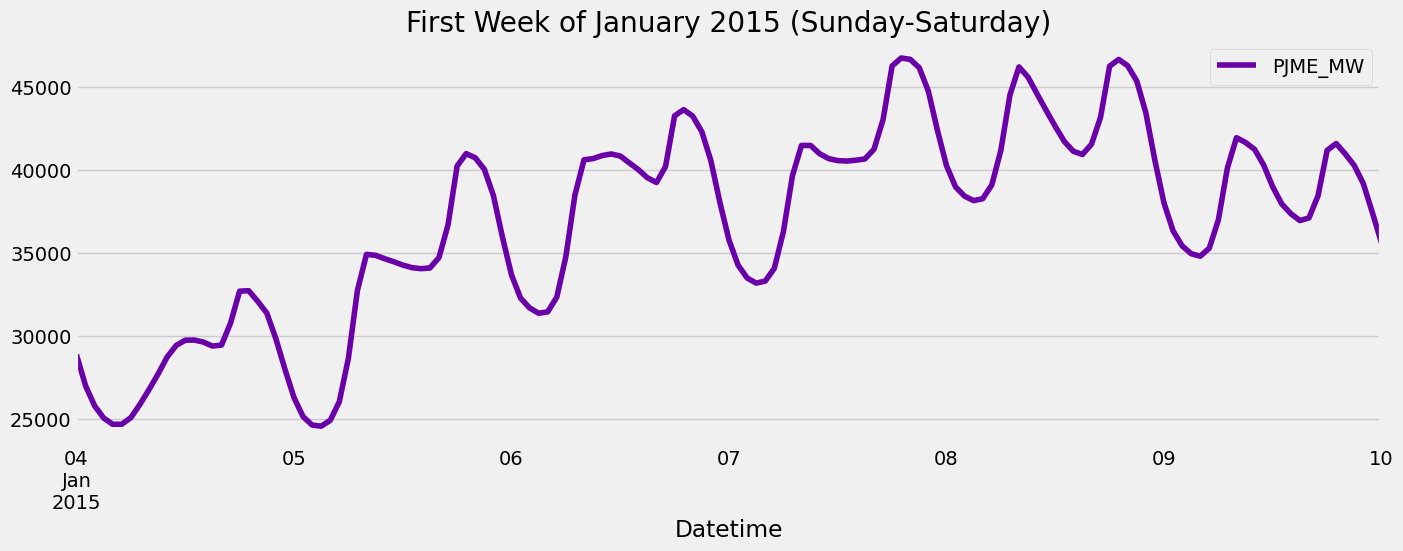

In [ ]:
# Looking closer at the first week in january
one_week = df.loc[(df.index >= '2015-01-04') & (df.index <= '2015-01-10')]

# Plotting one week of data
ax = one_week.plot(figsize=(15, 5),
              title="First Week of January 2015 (Sunday-Saturday)",
              color=colors[0])


plt.show()

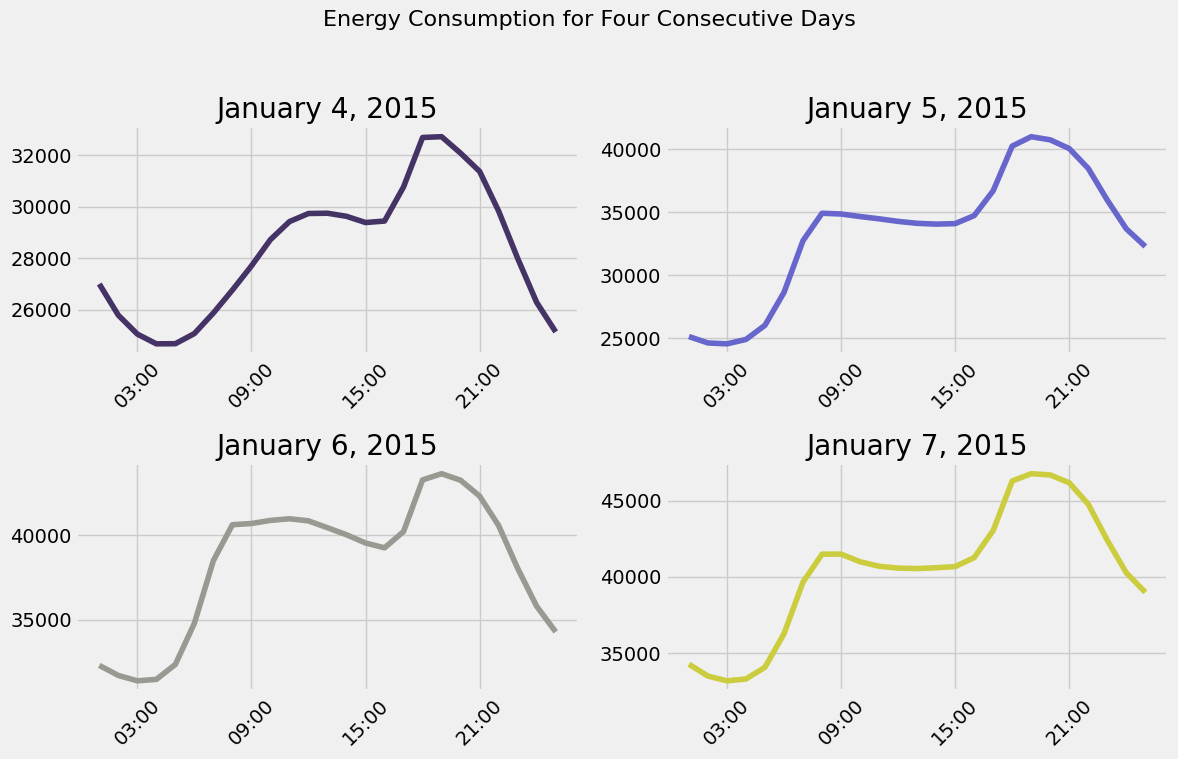

In [ ]:
# Pulling out one day of data
day_one = df.loc[(df.index >= '2015-01-04 01:00:00') & (df.index <= '2015-01-05 01:00:00')]
day_two = df.loc[(df.index >= '2015-01-05 01:00:00') & (df.index <= '2015-01-06 01:00:00')]
day_three = df.loc[(df.index >= '2015-01-06 01:00:00') & (df.index <= '2015-01-07 01:00:00')]
day_four = df.loc[(df.index >= '2015-01-07 01:00:00') & (df.index <= '2015-01-08 01:00:00')]
days = [day_one, day_two, day_three, day_four]
day_labels = ['January 4, 2015', 'January 5, 2015', 'January 6, 2015', 'January 7, 2015']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption for Four Consecutive Days', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('gist_stern', 4)

for i, day in enumerate(days):
    axes[i].plot(day.index, day['PJME_MW'], color=colors[i])
    axes[i].set_title(day_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Show hours and minutes
    
    
    axes[i].tick_params(axis='x', rotation=45)  # Optionally rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

We will investigate further by plotting the averages!

# Splitting Data Into Train / Test Sets

In [ ]:
# Function to split data at Jan 1 2015 for use later
def split_data(df, split_date='01-01-2015'):
    """
    Split dataframe into a train and a test set
    """
    train = df.loc[df.index < split_date]
    test = df.loc[df.index >= split_date]
    return train, test

train, test = split_data(df)

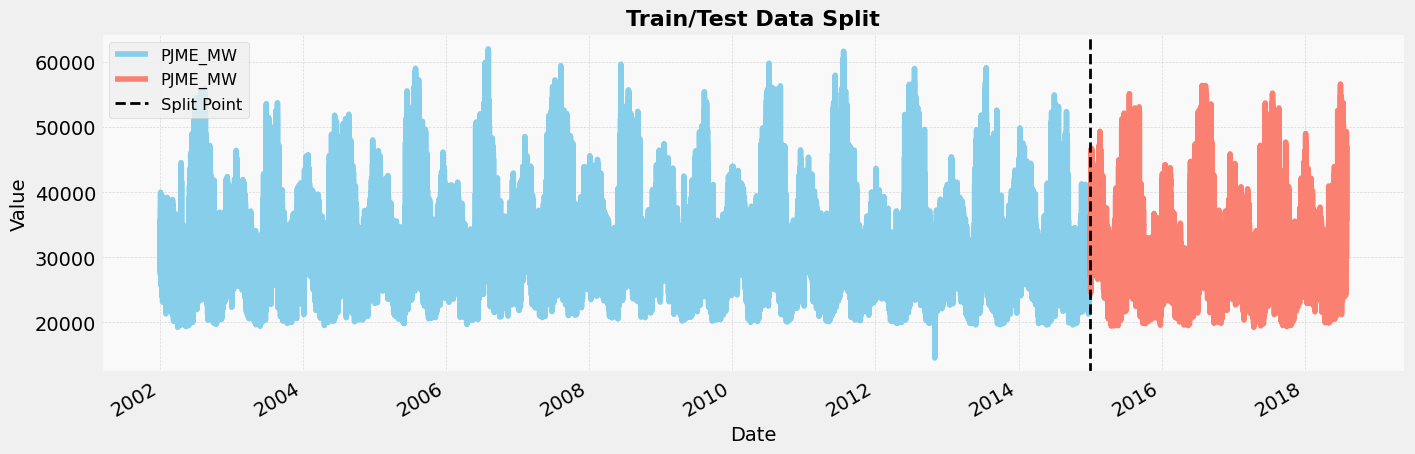

In [ ]:
# Visualizing our train/test split
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, color='skyblue', label='Training Set')
test.plot(ax=ax, color='salmon', label='Test Set')

ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--', lw=2, label='Split Point')

# Customization
ax.set_title('Train/Test Data Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.legend(fontsize='small', loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

# Feature Creation

In [ ]:
import holidays

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return add_holidays(df)

def add_holidays(df, country='US'):
    """
    Create binary feature to indicate whether that day is a holiday or not
    """
    df = df.copy()
    
    # Create an instance of the holiday class for the specified country
    holiday_list = holidays.CountryHoliday(country)
    
    # Make a new column with '0' for non-holidays and '1' for holidays
    df['holiday'] = df.index.map(lambda x: x in holiday_list).astype(int)
    
    return df
    
df_original = df.copy()
df = create_features(df)
df = add_holidays(df)

In [ ]:
christmas = df.loc[df.index == '2015-12-25']
new_years = df.loc[df.index == '2016-01-01']
random_day = df.loc[df.index == '2016-01-02']
print('christmas',christmas['holiday'])
print('new years',new_years['holiday'])
print('non-holiday',random_day['holiday'])

christmas Datetime
2015-12-25    1
Name: holiday, dtype: int32
new years Datetime
2016-01-01    1
Name: holiday, dtype: int32
non-holiday Datetime
2016-01-02    0
Name: holiday, dtype: int32


# Using Facebook's Prophet to Forecast Energy Consumption


In [ ]:
# Reset our dataframe and split again
df = df_original.copy()
train, test = split_data(df)

Prophet takes a specific format of data that is not datetime it is 'ds'. We must convert our data back to datetime. 

In [ ]:
# Format data for prophet model using ds and y
prophet_train = train.reset_index() \
    .rename(columns={'Datetime':'ds','PJME_MW':'y'})
prophet_train.head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


### A note about prophet before feature creation
Prophet does not take in time features in the same way that xgboost does. Prophet natively models trends, seasonality (daily, weekly, yearly), and holidays, but it does not directly accept arbitrary features like "hour of the day" in the same way a model like XGBoost does. However, it is designed to incorporate holidays, by adding a column 'holiday' in the dataframe. To most fairly compare the models we will add holidays for prophet as well.

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Create a dataframe with holiday, ds columns
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2002-01-01 01:00:00,USFederalHoliday
1,2002-01-01 02:00:00,USFederalHoliday
2,2002-01-01 03:00:00,USFederalHoliday
3,2002-01-01 04:00:00,USFederalHoliday
4,2002-01-01 05:00:00,USFederalHoliday


In [ ]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [ ]:
# Set up and train model
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

22:31:59 - cmdstanpy - INFO - Chain [1] start processing
22:34:38 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Predict on training set with model
prophet_fcst = prophet_model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [ ]:
prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31263.761899,24144.597624,33067.595438,31263.761899,31263.761899,-1839.94345,-1839.94345,-1839.94345,-2486.707263,...,1298.687352,1298.687352,1298.687352,466.976984,466.976984,466.976984,0.0,0.0,0.0,28777.054637
1,2015-01-01 01:00:00,31263.724936,22223.797445,31117.174434,31263.724936,31263.724936,-1839.94345,-1839.94345,-1839.94345,-4509.642364,...,1292.582793,1292.582793,1292.582793,468.275898,468.275898,468.275898,0.0,0.0,0.0,26754.082571
2,2015-01-01 02:00:00,31263.687972,20744.674295,30007.504649,31263.687972,31263.687972,-1839.94345,-1839.94345,-1839.94345,-6012.823936,...,1284.803067,1284.803067,1284.803067,469.612489,469.612489,469.612489,0.0,0.0,0.0,25250.864036
3,2015-01-01 03:00:00,31263.651008,20105.325349,28683.961436,31263.651008,31263.651008,-1839.94345,-1839.94345,-1839.94345,-6883.716634,...,1275.461156,1275.461156,1275.461156,470.986786,470.986786,470.986786,0.0,0.0,0.0,24379.934373
4,2015-01-01 04:00:00,31263.614044,20035.536994,28905.197246,31263.614044,31263.614044,-1839.94345,-1839.94345,-1839.94345,-7024.928447,...,1264.690197,1264.690197,1264.690197,472.398818,472.398818,472.398818,0.0,0.0,0.0,24238.685597


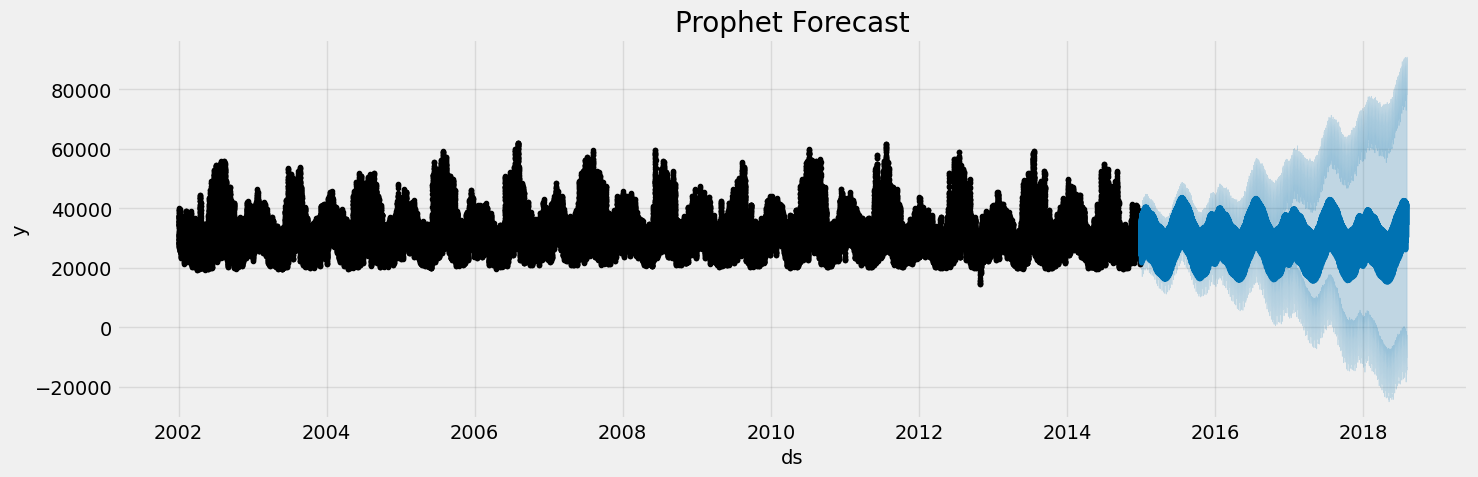

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_model.plot(prophet_fcst,ax=ax)
plt.show()

It appears the model understands the general seasonality of our data, while similar to XGBoost can't predict the full range of consumption with confidence. Although, the less confident forecasts do reach the full range of consumption.

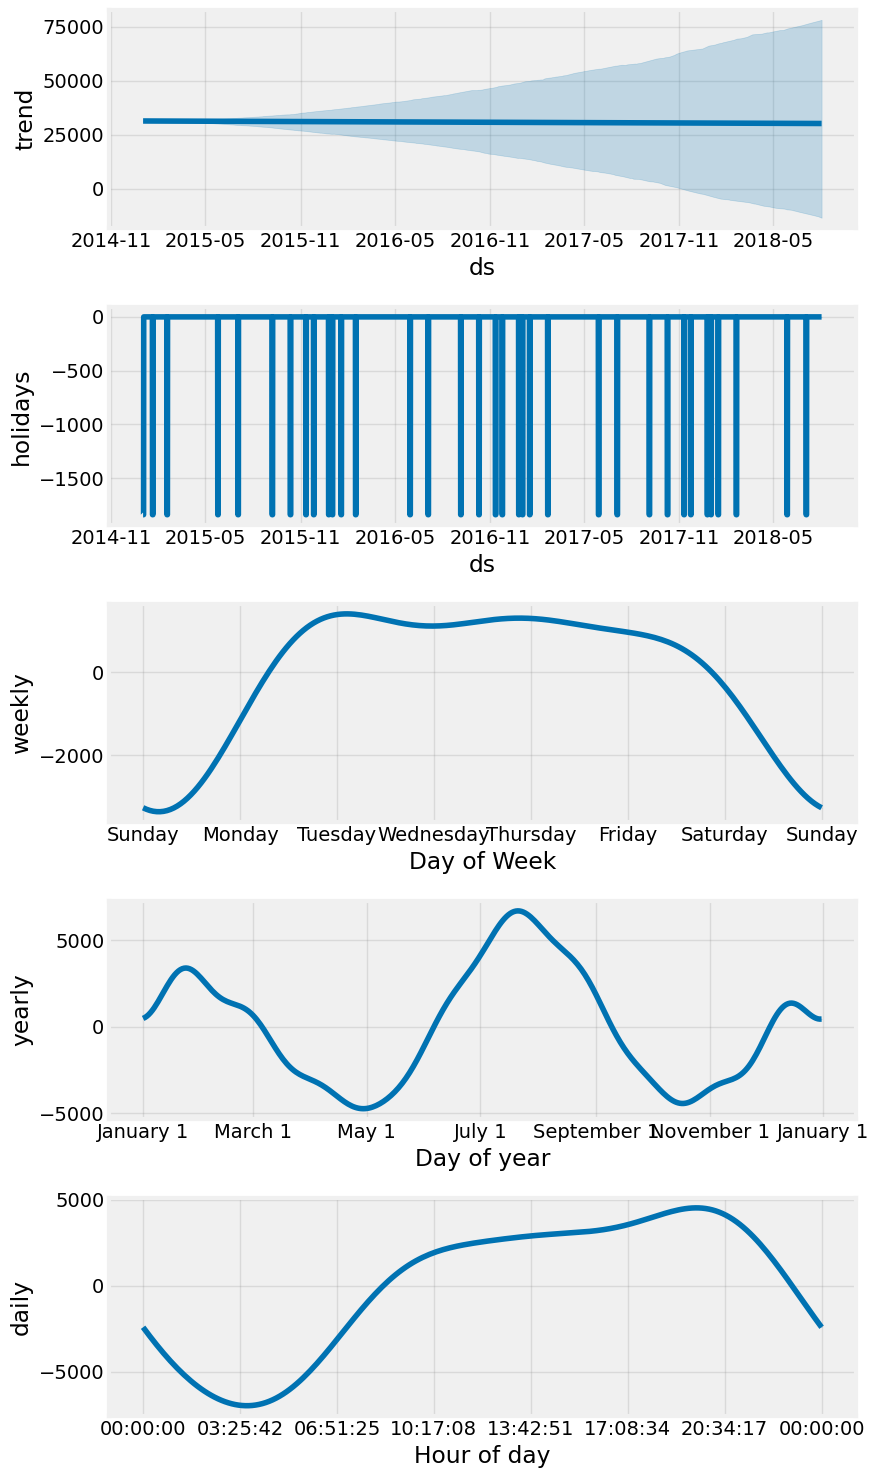

In [ ]:
# Plotting the components of the model

warnings.simplefilter("ignore", FutureWarning)
fig = prophet_model.plot_components(prophet_fcst)

These broken down trends the model was able to learn look **very** similar to the visualizations we made plotting the average distributions across different lags. It seems like prophet does a good job of understanding the overall structure of our data.

### Comparing Forecast to Actual Values

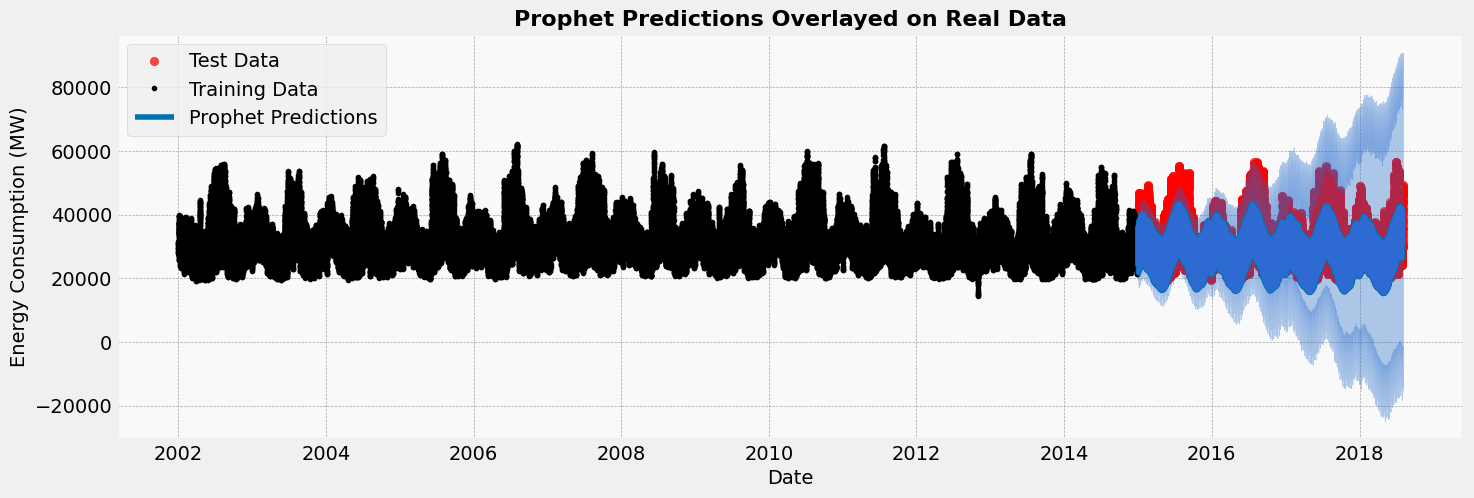

In [ ]:
# Set up the plot
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot real test data
ax.scatter(test.index, test['PJME_MW'], color='red', alpha=0.7, label='Real Data')

fig = prophet_model.plot(prophet_fcst, ax=ax, plot_cap=False)

# Plot prophet forecasts
ax.plot(prophet_fcst['ds'], prophet_fcst['yhat'], color='royalblue', linewidth=2.5, alpha=0.7, label='Prophet Predictions')
ax.fill_between(prophet_fcst['ds'], prophet_fcst['yhat_lower'], prophet_fcst['yhat_upper'], color='royalblue', alpha=0.2)

ax.set_title('Prophet Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area
plt.legend(['Test Data', 'Training Data', 'Prophet Predictions'], fontsize='medium', loc='upper left')

plt.show()

## Prophet Model Error Metrics

In [ ]:
prophet_MAE = mean_absolute_error(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Error Score on Test set: {prophet_MAE:0.2f}')

Mean Absolute Error Score on Test set: 3102.92


In [ ]:
prophet_rmse = sqrt(mean_squared_error(test['PJME_MW'], prophet_fcst['yhat']))
print(f'RMSE Score on Test set: {prophet_rmse:0.2f}')

RMSE Score on Test set: 4116.50


In [ ]:
prophet_MAPE = mape(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Percent Error Score on Test set: {prophet_MAPE:0.2f}')

Mean Absolute Percent Error Score on Test set: 9.62


# Summary of Findings

## Prophet Performance
- **MAE**: 3102.92
- **RMSE**: 4116.50
- **MAPE**: 9.62%
